## Теоретическая часть

#### 1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  В чем принципиальные отличия item-item рекомендаций от ALS?

1. Отличие user-user и item-item рекомендации заключается в количестве. Как правило количество юзеров может расти быстрей и больше чем количество товаров ...
2. Да можно, т.к. мы производим расчеты на одной и той же матрице. Просто нужно ее транпонировать перед тем как подавать в функцию item_item_rec

3. Принципиальное отличие заключается в нахождении градинта в методе ALS, тогда как в ItemItem мы просто считаем похожесть товаров(пользоватлей).

#### 2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


В качестве весов можно использовать количество лайков, рейтинг товара, 

#### 3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


плохо работает с категориальными признаками,

#### 4. Мы рассматривали bm_25_weight. Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

## Практическая часть


In [1]:
%matplotlib inline

import implicit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
from implicit.nearest_neighbours import ItemItemRecommender

from src.metrics import precision_at_k

In [2]:
item_of_nines = 999999

In [3]:
def train_test_split_by_week(df, name_of_week_column, test_size_weeks):
    
    week_ratio = df[name_of_week_column].max() - test_size_weeks
    
    df_train = df[df[name_of_week_column] < week_ratio]
    df_test = df[df[name_of_week_column] >= week_ratio]
    
    return df_train, df_test

In [4]:
def group_df_by(df, grouped_feat, second_feat, new_name_of_second_feat, pick_method):
    
    if pick_method == 'unique':
        grouped_df = df.groupby(grouped_feat)[second_feat].unique().reset_index()
        grouped_df.rename(columns={second_feat: new_name_of_second_feat}, inplace=True)
    
    elif pick_method == 'sum':
        grouped_df = df.groupby(grouped_feat)[second_feat].sum().reset_index()
        grouped_df.rename(columns={second_feat: new_name_of_second_feat}, inplace=True)
    
    return grouped_df

In [5]:
def df_to_user_item_matrix(df, top_items):
    df_of_top = df.copy()
    df_of_top.loc[~df_of_top['item_id'].isin(top_items), 'item_id'] = item_of_nines

    user_item_matrix = pd.pivot_table(df_of_top, 
                                      index='user_id', 
                                      columns='item_id', 
                                      values='quantity', 
                                      aggfunc='count', 
                                      fill_value=0)

    user_item_matrix = user_item_matrix.astype(float)

    sparce_user_item = csr_matrix(user_item_matrix).tocsr()

    sparce_t_user_item = csr_matrix(user_item_matrix).T.tocsr()
    
    return df_of_top, user_item_matrix, sparce_user_item, sparce_t_user_item

In [6]:
def group_df_train_and_test(train, test, groupby_feat, second_feat, rename_column, aggfunc):
    
    assert aggfunc in ['unique', 'sum'], 'aggfunc принимает значения unique, sum'
    
    train_df = group_df_by(train, groupby_feat, second_feat, rename_column, aggfunc)
    test_df = group_df_by(test, groupby_feat, second_feat, rename_column, aggfunc)
        
    return train_df, test_df

In [7]:
def change_ids(matrix):
    user_id = matrix.index.values
    item_id = matrix.columns.values
    
    matrix_user_id = np.arange(len(user_id))
    matrix_item_id = np.arange(len(item_id))
    
    id_to_user_id = dict(zip(matrix_user_id, user_id))
    id_to_item_id = dict(zip(matrix_item_id, item_id))
    
    user_id_to_id = dict(zip(user_id, matrix_user_id))
    item_id_to_id = dict(zip(item_id, matrix_item_id))
    
    return id_to_user_id, id_to_item_id, item_id_to_id, user_id_to_id

In [8]:
def get_recommendation(user, model, sparce_user_item, id_to_item_id, user_id_to_id, N=5):
    
    res = [id_to_item_id[rec[0]] for rec in model.recommend(userid=user_id_to_id[user], 
                                                            user_items=sparce_user_item, 
                                                            N=N, 
                                                            filter_already_liked_items=False, 
                                                            filter_items=None, 
                                                            recalculate_user=True)]
    
    return res

In [9]:
def grid_search(train, test, reg_list, factors_list, sparce_t_matrix_train, 
                sparce_matrix_train, id_to_item_id_train, user_id_to_id_train):
    
    result_train_list = []
    result_test_list = []
    
    for alpha in reg_list:

        for factors in factors_list:
            
            model2 = AlternatingLeastSquares(factors=factors, 
                                    regularization=alpha, 
                                    iterations=15, 
                                    calculate_training_loss=True)
            print(f'Модель с regularization = {alpha}, factors = {factors}')
            model2.fit(sparce_t_matrix_train, show_progress=True)
            
            # Train
            train[f'als_l_{alpha}__factors_{factors}'] = \
                train['user_id'].apply(lambda x: get_recommendation(x, model=model2, 
                                                                     sparce_user_item=sparce_matrix_train, 
                                                                     id_to_item_id=id_to_item_id_train, 
                                                                     user_id_to_id=user_id_to_id_train))

            train[f'als_prec_l_{alpha}__factors_{factors}'] = \
                train.apply(lambda x: precision_at_k(x[f'als_l_{alpha}__factors_{factors}'], x['boughted']), 
                                                                            axis=1)
            precision_train_mean = train[f'als_prec_l_{alpha}__factors_{factors}'].mean()
            
            # Test
            
            test[f'als_l_{alpha}__factors_{factors}'] = \
                test['user_id'].apply(lambda x: get_recommendation(x, model=model2, 
                                                                     sparce_user_item=sparce_matrix_train, 
                                                                     id_to_item_id=id_to_item_id_train, 
                                                                     user_id_to_id=user_id_to_id_train))

            test[f'als_prec_l_{alpha}__factors_{factors}'] = \
                test.apply(lambda x: precision_at_k(x[f'als_l_{alpha}__factors_{factors}'], x['boughted']), 
                                                                            axis=1)
            
            precision_test_mean = test[f'als_prec_l_{alpha}__factors_{factors}'].mean()

            result_train_list.append((alpha, factors, precision_train_mean))
            result_test_list.append((alpha, factors, precision_test_mean))
            
    return result_train_list, result_test_list

In [10]:
def train_test_scores_plot(df):
    factors = df['factors'].values.tolist()
    train_scores = df['train_mean_precision'].values.tolist()
    test_scores = df['test_mean_precision'].values.tolist()
    
    plt.plot(factors, train_scores, label='Train line')
    plt.plot(factors, test_scores, label='Test line')
    
    plt.legend()
    
    plt.show()

In [11]:
data = pd.read_csv('../урок 2/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id', 
                     'product_id': 'item_id'}, 
            inplace=True)

data_train, data_test = train_test_split_by_week(data, 'week_no', 3)

In [12]:
data_train.shape, data_test.shape

((2278490, 12), (118314, 12))

In [13]:
result_train, result_test = group_df_train_and_test(data_train, 
                                                    data_test, 
                                                    'user_id', 
                                                    'item_id', 
                                                    'boughted', 
                                                    'unique')

In [14]:
result_train.head(2)

,user_id,boughted
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [15]:
result_test.head(2)

,user_id,boughted
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [16]:
popular_items_train, popular_items_test = group_df_train_and_test(data_train, 
                                                                  data_test, 
                                                                  'item_id', 
                                                                  'quantity', 
                                                                  'n_sold', 
                                                                  'sum')

In [17]:
popular_items_train.head(2)

,item_id,n_sold
0,25671,6
1,26081,1


In [18]:
popular_items_test.head(2)

,item_id,n_sold
0,29512,1
1,30356,1


In [19]:
top_5000_train = popular_items_train.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
top_5000_test = popular_items_test.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [20]:
df_top_5000_train, \
u_i_matrix_train, \
sparce_u_i_train, \
sparce_t_u_i_train = df_to_user_item_matrix(data_train, top_items=top_5000_train)

In [21]:
df_top_5000_test,\
u_i_matrix_test,\
sparce_u_i_test,\
sparce_t_u_i_test = df_to_user_item_matrix(data_test, top_items=top_5000_test)

In [22]:
id_to_user_id_train, \
id_to_item_id_train, \
item_id_to_id_train, \
user_id_to_id_train = change_ids(u_i_matrix_train)

In [23]:
id_to_user_id_test, \
id_to_item_id_test, \
item_id_to_id_test, \
user_id_to_id_test = change_ids(u_i_matrix_test)

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [24]:
model = AlternatingLeastSquares(factors=100, 
                                regularization=1e-3, 
                                iterations=15, 
                                calculate_training_loss=True,
                                num_threads=1)

model.fit(sparce_t_u_i_train, show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

In [25]:
%%time

result_train['als_recommendation'] = result_train['user_id']\
                                        .apply(lambda x: get_recommendation(x, model=model, 
                                                                           sparce_user_item=sparce_u_i_train, 
                                                                           id_to_item_id=id_to_item_id_train, 
                                                                           user_id_to_id=user_id_to_id_train))

CPU times: user 1min 16s, sys: 2.17 s, total: 1min 18s
Wall time: 45.1 s


In [26]:
result_train['als_precision'] = result_train.apply(lambda x: precision_at_k(x['als_recommendation'],
                                                                            x['boughted']), 
                                                   axis=1)

In [27]:
result_train['als_precision'].mean()

0.7362144857943039

In [28]:
%%time

result_test['als_recommendation'] = result_test['user_id']\
                                        .apply(lambda x: get_recommendation(x, model=model, 
                                                                           sparce_user_item=sparce_u_i_train, 
                                                                           id_to_item_id=id_to_item_id_train, 
                                                                           user_id_to_id=user_id_to_id_train))

CPU times: user 1min 10s, sys: 2.11 s, total: 1min 12s
Wall time: 41.3 s


In [29]:
result_test['als_precision'] = result_test.apply(lambda x: precision_at_k(x['als_recommendation'],
                                                                            x['boughted']), 
                                                   axis=1)

In [30]:
result_test['als_precision'].mean()

0.15964740450538464

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [31]:
alpha_list = [1e-1, 1e-2, 1e-3, 1e-4]
n_factors = [0, 50, 100, 150, 200]

In [32]:
result_train_list, result_test_list = grid_search(result_train, 
                                                  result_test, 
                                                  alpha_list, n_factors, 
                                                  sparce_t_u_i_train, sparce_u_i_train, 
                                                  id_to_item_id_train, user_id_to_id_train)

Модель с regularization = 0.1, factors = 0


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.1, factors = 50


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.1, factors = 100


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.1, factors = 150


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.1, factors = 200


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.01, factors = 0


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.01, factors = 50


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.01, factors = 100


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.01, factors = 150


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.01, factors = 200


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.001, factors = 0


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.001, factors = 50


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.001, factors = 100


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.001, factors = 150


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.001, factors = 200


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.0001, factors = 0


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.0001, factors = 50


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.0001, factors = 100


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.0001, factors = 150


  0%|          | 0/15 [00:00<?, ?it/s]

Модель с regularization = 0.0001, factors = 200


  0%|          | 0/15 [00:00<?, ?it/s]

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

In [33]:
a = np.array(result_train_list)
b = np.array(result_test_list)

In [34]:
result_train_test_list = np.hstack((a, b[:,2:]))

In [35]:
df_results = pd.DataFrame(result_train_test_list, 
                          columns=['reg', 'factors', 'train_mean_precision', 'test_mean_precision'])
df_results.head(2)

,reg,factors,train_mean_precision,test_mean_precision
0,0.1,0.0,0.060264,0.006856
1,0.1,50.0,0.629292,0.167385


In [36]:
reg_1e_1 = df_results.loc[df_results['reg'] == 1e-1, ['factors', 'train_mean_precision', 'test_mean_precision']]
reg_1e_2 = df_results.loc[df_results['reg'] == 1e-2, ['factors', 'train_mean_precision', 'test_mean_precision']]
reg_1e_3 = df_results.loc[df_results['reg'] == 1e-3, ['factors', 'train_mean_precision', 'test_mean_precision']]
reg_1e_4 = df_results.loc[df_results['reg'] == 1e-4, ['factors', 'train_mean_precision', 'test_mean_precision']]

### На графиках ниже описана зависимость качства от n_factors при определенном значении регуляризации

#### Значение регуляризации 0.1

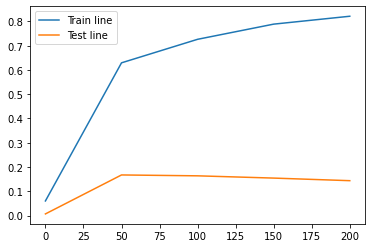

In [37]:
train_test_scores_plot(reg_1e_1)

##### Значение регуляризации 0.01

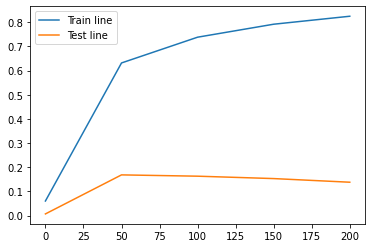

In [38]:
train_test_scores_plot(reg_1e_2)

##### Значение регуляризации 0.001

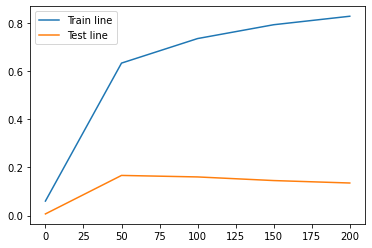

In [39]:
train_test_scores_plot(reg_1e_3)

##### Значение регуляризации 0.0001

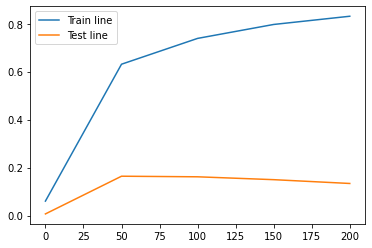

In [40]:
train_test_scores_plot(reg_1e_4)

In [50]:
df_results[df_results['test_mean_precision'] == df_results['test_mean_precision'].max()]

,reg,factors,train_mean_precision,test_mean_precision
6,0.01,50.0,0.631533,0.168364


In [54]:
iterations_list = [20, 30, 45]
result_iterations = []
for iteration in iterations_list:
    
    best_model = AlternatingLeastSquares(factors=50, 
                                    regularization=1e-2, 
                                    iterations=iteration, 
                                    calculate_training_loss=True,
                                    num_threads=1)

    best_model.fit(sparce_t_u_i_train, show_progress=True)

    result_test[f'als_{iteration}iterations_recommendation'] = result_test['user_id']\
                                            .apply(lambda x: get_recommendation(x, model=model, 
                                                                               sparce_user_item=sparce_u_i_train, 
                                                                               id_to_item_id=id_to_item_id_train, 
                                                                               user_id_to_id=user_id_to_id_train))

    result_test[f'als_{iteration}iterations_precision'] = result_test.apply(lambda x: precision_at_k(x[f'als_{iteration}iterations_recommendation'], 
                                                                              x['boughted']), 
                                                       axis=1)
    result_train[f'als_{iteration}iterations_recommendation'] = result_train['user_id']\
                                            .apply(lambda x: get_recommendation(x, model=model, 
                                                                               sparce_user_item=sparce_u_i_train, 
                                                                               id_to_item_id=id_to_item_id_train, 
                                                                               user_id_to_id=user_id_to_id_train))

    result_train[f'als_{iteration}iterations_precision'] = result_train.apply(lambda x: precision_at_k(x[f'als_{iteration}iterations_recommendation'], 
                                                                              x['boughted']), 
                                                       axis=1)
    train_mean_precition = result_train[f'als_{iteration}iterations_precision'].mean()
    test_mean_precition = result_test[f'als_{iteration}iterations_precision'].mean()
    
    result_iterations.append([iteration, train_mean_precition, test_mean_precition])
    
    

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [55]:
result_iterations

[[20, 0.7362144857943039, 0.15964740450538464],
 [30, 0.7362144857943039, 0.15964740450538464],
 [45, 0.7362144857943039, 0.15964740450538464]]

Из графиков выше видно что регуляризация не так сильно влияет на конечную метрику как число факторов. Но все же снижение регуляризации немного увеличивает качетво precition@k